# Lab 2



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from typing import List, Tuple, Dict, Any, Optional

import scipy.stats as stats 
from scipy.stats import poisson, expon
from scipy.integrate import quad

plt.style.use('default')

## Question 1

**Non-homogeneous Poisson process and trade times**

Implement a thinning algorithm for the simulation of a non-homogeneous Poisson process on $[0, T]$ with a given intensity $\mu: [0, T] \rightarrow \mathbb{R}_+$. Make some tests to check that your simulation algorithm is correct. Propose/calibrate a deterministic intensity function $f$ that represents the intensity of occurrence of trades during a trading day. Using simulations of a (non-homogeneous) Poisson process with intensity $f$, comment on the statistical properties of the fitted model and on the goodness-of-fit of this model.


First, we are going to implement first a Time-homogeneous Poisson process simulation.

We will use the statistics simulation:

In [2]:
def time_homogeneous_poisson_process(lmbda, T):
    
    n_events = poisson.rvs(lmbda*T)
    random_positions = np.random.uniform(0, T, n_events)
    random_positions.sort()
    
    return random_positions

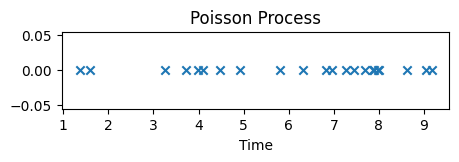

In [3]:
T = 10
lmbda = 2

poisson_process = time_homogeneous_poisson_process(lmbda, T)

plt.figure(figsize=(5, 1))
plt.title('Poisson Process')
plt.scatter(poisson_process, np.zeros_like(poisson_process), marker='x')
plt.xlabel('Time')
plt.show()

In [4]:
def nhpp_thinning (lmbda, T):
    
    # Finding the highest rate
    x_space = np.linspace(0, T, int(T * 1000))
    y_space = lmbda(x_space)
    y_space = y_space[~np.isnan(y_space)]
    lmbda_star = int( np.ceil( np.max(y_space) ) ) + 1
    
    homogenous_poisson_process = time_homogeneous_poisson_process(
        lmbda_star, T)
    
    # Thinning
    thinning_prob = np.random.uniform(0, 1, len(homogenous_poisson_process))
    lam_values = lmbda(homogenous_poisson_process)
    mask = thinning_prob < ( lam_values / lmbda_star )
    
    return homogenous_poisson_process[mask]

Elements in nhpp 37
Time x Rate: 37.69911184307751


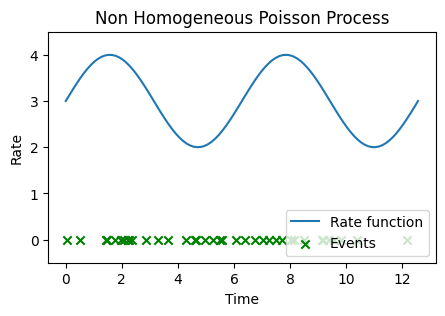

In [5]:
mu = lambda x: 3 + np.sin(x)
T = (2 * np.pi) * 2
nhpp =  nhpp_thinning(mu, T)

print("Elements in nhpp", len(nhpp))
print("Time x Rate:", T * mu(T))

plt.figure(figsize=(5, 3))
plt.title('Non Homogeneous Poisson Process')
plt.plot(np.linspace(0, T, 100), 
         mu(np.linspace(0, T, 100)), label='Rate function')
plt.scatter(nhpp, np.zeros_like(nhpp), marker='x', label='Events',
            color='g')
plt.ylabel('Rate') 
plt.xlabel('Time')
plt.ylim(-0.5, 4.5)
plt.legend()
plt.show()

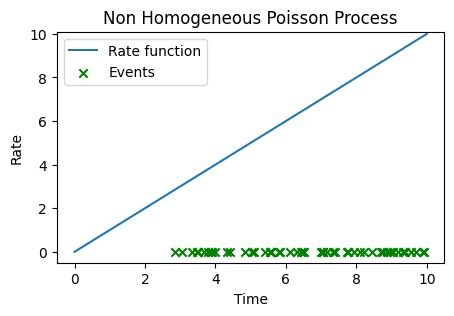

In [6]:
mu = lambda x: x
T = 10
nhpp =  nhpp_thinning(mu, T)

plt.figure(figsize=(5, 3))
plt.title('Non Homogeneous Poisson Process')
plt.plot(np.linspace(0, T, 100), 
         mu(np.linspace(0, T, 100)), label='Rate function')
plt.scatter(nhpp, np.zeros_like(nhpp), marker='x', label='Events',
            color='g')
plt.ylabel('Rate')
plt.xlabel('Time')
plt.ylim(-0.5, 10.1)
plt.legend()
plt.show()

### Algorithm testing

We want to do some tests to check that our simulation algorithm is correct. We will use the following proposition:

> **Proposition:** T Let $ \tilde{N} $ be a non-homogeneous Poisson process with intensity $ t \mapsto \lambda(t) $. Let $ (S_i)_{i \geq 1} $ be the random times of counted events. Then the random variables $ (\Lambda(S_i) - \Lambda(S_{i-1}))_{i \geq 2} $ are *i.i.d.* random variables, *exponentially distributed* with parameter $ 1 $.

where $ \Lambda(t) = \int_0^t \lambda(s) \, ds $ is the cumulative intensity function.

In [7]:
def Lambda (t, lmbda):
    if t <= 5:
        limit = 50
    else:
        limit = int(t * 2 * np.pi)
    integral, _ = quad(lmbda, 0, t, limit= limit)
    return integral

Therefore, if we apply to each time the intensity function, we should get an exponential distribution with parameter $ 1 $.

In [8]:
mu = lambda x: 10 + 5 * np.sin(x) + 2 * np.sin(2 * x)
T = (2 * np.pi) * 100
print("Max T", T)
nhpp =  nhpp_thinning(mu, T)
nhpp.sort()

Max T 628.3185307179587


In [9]:
lambda_nhpp = np.array([Lambda(x, mu) for x in nhpp])
data = np.diff(lambda_nhpp)

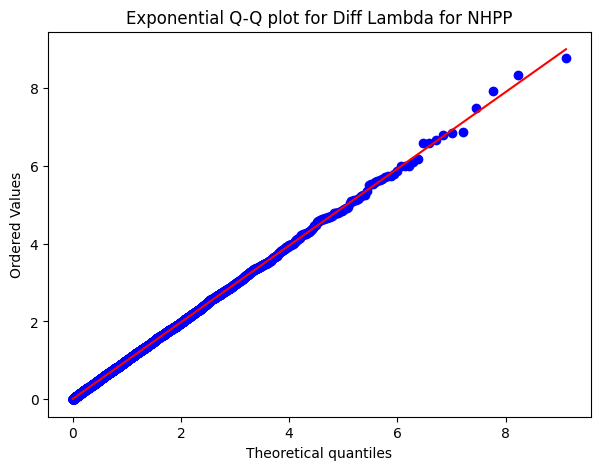

In [10]:
plt.figure(figsize=(7, 5))
stats.probplot(data, dist='expon', sparams=(0, 1), plot=plt)
plt.title('Exponential Q-Q plot for Diff Lambda for NHPP')
plt.show()


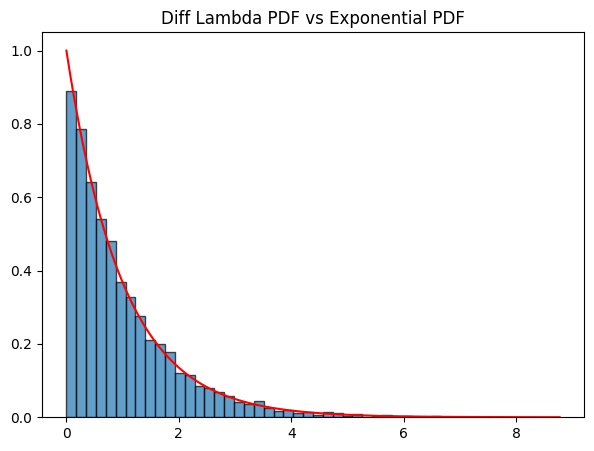

In [11]:
x = np.linspace(data.min(), data.max(), 1000)
pdf = expon.pdf(x, scale=1)

plt.figure(figsize=(7, 5))
plt.hist(data, edgecolor="black",
         bins=50, density=True, alpha=0.7, label='Diff Lambda')
plt.plot(x, pdf, label='Exponential PDF', color='r')
plt.title('Diff Lambda PDF vs Exponential PDF')
plt.show()

Using Kolmogorov-Smirnov test, we can check if the distribution of the simulated data is the same as the exponential distribution.

- Null hypothesis: The distribution of the simulated data is the same as the exponential distribution.
- Alternative hypothesis: The distribution of the simulated data is not the same as the exponential distribution.

In [12]:
stat, p_value = stats.kstest(data, 'expon', args=(0, 1))
print("KS Test Statistic:", stat)
print("P-Value:", p_value)

KS Test Statistic: 0.008332332419800581
P-Value: 0.7695716894910005


From the qq-plot, we can see that the data is fairly well fitted by the exponential distribution. In higher values, they do follow the trend, yet with a bit of unstability. This might be given by numerical unstability or by the fact that the data is not perfectly exponential.

From the second plot, we can the that the empirical histrogram follows the exponential distribution. So by observing this graph, the data is failry well fitted to the exponential distribution.

From the Kolmogorov-Smirnov test, we can see that the p-value is very high, so we fail to reject the null hypothesis. Therefore, we can say that the data is well fitted to the exponential distribution.

In conclusion, the data is well fitted to be exponential distribution, with some little unstabilities for difference values.

### Propose / Calibrate a deterministic intensity function with the intensity of occurrence of trades during a trading day

I will use the previous lab sanity check to the data we are using.

In [13]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

files = get_all_files(os.path.join('data', 'SG'))

dfs = []

for i, file in enumerate(files):
    df_small = pd.read_csv(os.path.join('data', 'SG', file), index_col = 0)
    dfs.append(df_small)
    if i == 0:
        break  # < ----------------- remove this line to read all files
df = pd.concat(dfs)
df['ets'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')
df = df.sort_values(by='ets')
df.head()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445


In [14]:
print(df.isna().sum())
print("---------------------------------------------------------------")
df.info()
print("---------------------------------------------------------------")
print(df.describe())
print("---------------------------------------------------------------")
print("Event type counts:\n", df['etype'].value_counts())

ets       0
etype     0
eprice    0
eqty      0
eside     0
bp0       0
bq0       0
ap0       0
aq0       0
dtype: int64
---------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 841149 entries, 0 to 841148
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ets     841149 non-null  datetime64[ns]
 1   etype   841149 non-null  object        
 2   eprice  841149 non-null  int64         
 3   eqty    841149 non-null  int64         
 4   eside   841149 non-null  object        
 5   bp0     841149 non-null  int64         
 6   bq0     841149 non-null  int64         
 7   ap0     841149 non-null  int64         
 8   aq0     841149 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 64.2+ MB
---------------------------------------------------------------
                                 ets         eprice           eqty  \
count      

In [184]:
group_stats = df.groupby('etype').agg({
    'eprice': ['mean', 'min', 'max'],
    'eqty': ['mean', 'min', 'max', 'count']
})
print(group_stats)

             eprice                      eqty                      
               mean    min    max        mean    min    max   count
etype                                                              
A      46153.362928  40000  60760  262.318794      1  25380  388981
C      46154.621730  41400  60760  256.661671      1  16107  377310
M      46127.718603  43410  58230  -33.332493 -14809  13751   61081
T      46134.648327  45510  46730  177.403644      1   7818   13777


In [185]:
# Check how often bid is not strictly below ask
invalid_quotes = df[df['bp0'] > df['ap0']]
if len(invalid_quotes) > 0:
    print("Crossed market found:\n", invalid_quotes)
else:
    print("No crossed markets detected.")

if (df['eqty'] < 0).any():
    print("WARNING: Negative eqty found.")
else:
    print("No neg eqty found.")

    
if (df['bq0'] < 0).any() or (df['aq0'] < 0).any():
    print("WARNING: Negative best quote sizes found.")
else:
    print("no negative best quote sizes found")


if (df['eprice'] <= 0).any():
    print("WARNING: Non-positive eprice found.")
else:
    print("No neg eprice")


No crossed markets detected.
no negative best quote sizes found
No neg eprice


In [186]:
# negative eqty filtering
df_negative_eqty = df[df['eqty'] < 0]
print(f"Number of negative eqty rows: {len(df_negative_eqty)}")
print(df_negative_eqty.head())

Number of negative eqty rows: 11110
                           ets etype  eprice  eqty eside    bp0   bq0    ap0  \
173 2017-01-17 09:01:09.766010     M   46195  -200     S  46040   660  46100   
245 2017-01-17 09:01:13.855505     M   46190  -200     S  46050   735  46100   
335 2017-01-17 09:01:16.658868     M   46050  -200     B  46100   530  46165   
358 2017-01-17 09:01:18.518978     M   46030  -200     B  46100   891  46165   
383 2017-01-17 09:01:22.111607     M   46240  -200     S  46100  1302  46165   

     aq0  
173   19  
245   19  
335  397  
358  397  
383  397  


**The data is clean.**

We will use the trading values, since they are the real deals being made, and we are studying these events.

In [187]:
df_trades = df[df['etype'] == 'T'].copy()
df_trades['ets'] = pd.to_datetime(df_trades['ets'])
df_trades = df_trades.set_index('ets').sort_index()

df_trades = df_trades.between_time('09:00:00', '17:30:00')

def add_daily_durations(group):
    group = group.sort_index()
    group['trade_duration'] = group.index.to_series().diff().dt.total_seconds()
    return group

df_trades = df_trades.groupby(df_trades.index.date, group_keys=False
                              ).apply(add_daily_durations)

df_trades = df_trades.dropna(subset=['trade_duration']) # first trade of each day
df_trades.head()

,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,trade_duration
ets,,,,,,,,,
2017-01-17 09:01:08.420222,T,46080,90,B,46010,1339,46085,1445,0.000012
2017-01-17 09:01:08.444495,T,46085,484,S,46010,855,46085,731,0.024273
2017-01-17 09:01:08.444769,T,46085,731,S,46010,855,46100,1000,0.000274
2017-01-17 09:01:08.639756,T,46080,310,B,46080,88,46100,1000,0.194987
2017-01-17 09:01:08.639768,T,46080,88,B,46030,446,46100,1000,0.000012


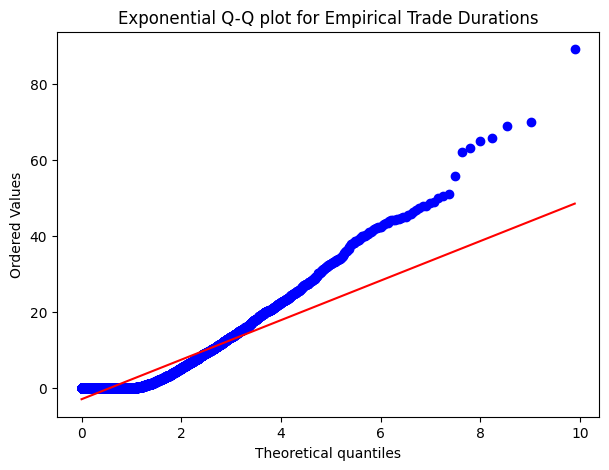

In [188]:
plt.figure(figsize=(7, 5))
stats.probplot(df_trades['trade_duration'], 
               dist='expon', sparams=(0, 1), plot=plt)
plt.title('Exponential Q-Q plot for Empirical Trade Durations')
plt.show()

In [189]:
stat, p_value = stats.kstest(df_trades['trade_duration'], 'expon', args=(0, 1))
print("KS Test Statistic:", stat)
print("P-Value:", p_value)

KS Test Statistic: 0.6111673268637242
P-Value: 0.0


From the lectures notes, the previous lab and from the previous graph and test, we can see that the empirical data doesnt follow an exponential law. 

To create the deterministic intensity function, we are going to use the simplest approach. We are going to consider a piecewise constant function, where we will divide the day by periods and we will calculate the intensity of each period.

In [190]:
df_trades.head(10)

,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,trade_duration
ets,,,,,,,,,
2017-01-17 09:01:08.420222,T,46080,90,B,46010,1339,46085,1445,0.000012
2017-01-17 09:01:08.444495,T,46085,484,S,46010,855,46085,731,0.024273
2017-01-17 09:01:08.444769,T,46085,731,S,46010,855,46100,1000,0.000274
2017-01-17 09:01:08.639756,T,46080,310,B,46080,88,46100,1000,0.194987
2017-01-17 09:01:08.639768,T,46080,88,B,46030,446,46100,1000,0.000012
2017-01-17 09:01:08.663081,T,46070,200,B,46070,20,46100,1000,0.023313
2017-01-17 09:01:08.663275,T,46070,20,B,46030,226,46100,1000,0.000194
2017-01-17 09:01:09.750807,T,46095,175,S,46035,517,46100,1000,1.087532
2017-01-17 09:01:09.750813,T,46100,981,S,46035,517,46100,19,0.000006


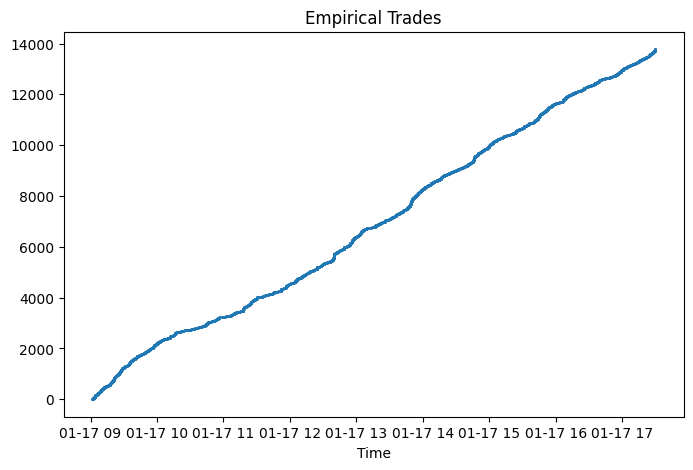

In [191]:
plt.figure(figsize=(8, 5))
plt.title('Empirical Trades')
plt.scatter(df_trades.index, 
            np.arange(1, len(df_trades.index) + 1), marker='.', s=1)
plt.xlabel('Time')
plt.show()

In [192]:
start_time = df_trades.index.min()
end_time = df_trades.index.max()
start_time, end_time

(Timestamp('2017-01-17 09:01:08.420222'),
 Timestamp('2017-01-17 17:29:59.997445'))

Number of trades per period:
day_period
(2017-01-17 13:41:00.787694650, 2017-01-17 14:06:27.366555800]    1066
(2017-01-17 09:01:08.420221999, 2017-01-17 09:26:34.999083150]    1065
(2017-01-17 09:26:34.999083150, 2017-01-17 09:52:01.577944300]     847
(2017-01-17 14:31:53.945416950, 2017-01-17 14:57:20.524278100]     822
(2017-01-17 12:24:41.051111200, 2017-01-17 12:50:07.629972350]     798
(2017-01-17 15:22:47.103139250, 2017-01-17 15:48:13.682000400]     793
(2017-01-17 12:50:07.629972350, 2017-01-17 13:15:34.208833500]     778
(2017-01-17 09:52:01.577944300, 2017-01-17 10:17:28.156805450]     714
(2017-01-17 15:48:13.682000400, 2017-01-17 16:13:40.260861550]     714
(2017-01-17 17:04:33.418583850, 2017-01-17 17:29:59.997445]        697
(2017-01-17 11:08:21.314527750, 2017-01-17 11:33:47.893388900]     684
(2017-01-17 11:59:14.472250050, 2017-01-17 12:24:41.051111200]     677
(2017-01-17 14:57:20.524278100, 2017-01-17 15:22:47.103139250]     619
(2017-01-17 13:15:34.208833500, 2017-

C:\Users\Marti\AppData\Local\Temp\ipykernel_19312\3402053398.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(pd.cut(df.index, bins=time_bins, include_lowest=True)).size()


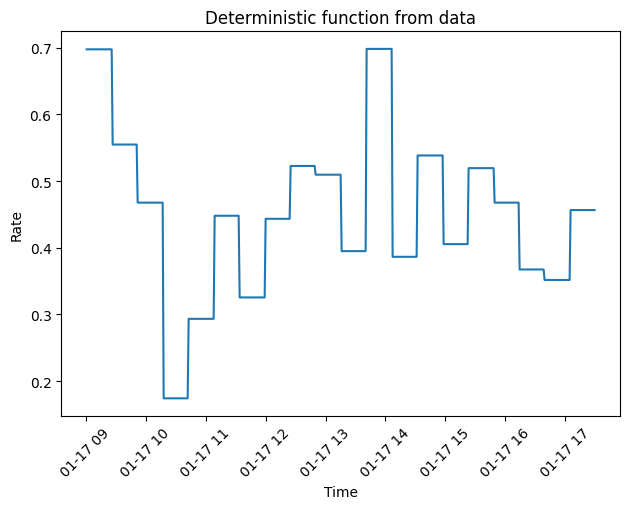

In [193]:
def create_deterministic_func(time_bins, df):

    counts = df.groupby(pd.cut(df.index, bins=time_bins, include_lowest=True)).size()
    period_seconds = np.array([(time_bins[i+1] - time_bins[i]).total_seconds() 
                               for i in range(len(time_bins)-1)])
    period_rate = counts.values / period_seconds

    start_time = time_bins[0]
    # Create numeric boundaries: seconds since the start time
    boundaries = np.array([(tb - start_time).total_seconds() for tb in time_bins])

    def single_rate(x):
        try:
            seconds = (x - start_time).total_seconds()
        except TypeError:
            seconds = x

        idx = np.searchsorted(boundaries, seconds, side='right') - 1
        if idx < 0 or idx >= len(period_rate):
            return np.nan
        return period_rate[idx]

    def piecewise_rate(timestamp):
        # If timestamp is scalar, process directly.
        if np.isscalar(timestamp) or \
            isinstance(timestamp, (pd.Timestamp)):
            return single_rate(timestamp)
        # Otherwise, assume timestamp is an array-like; vectorize the function.
        return np.array([single_rate(t) for t in timestamp])

    return piecewise_rate

num_periods = 20
time_bins = pd.date_range(start = start_time, end = end_time, 
                          periods = num_periods + 1)

df_trades['day_period'] = pd.cut(df_trades.index, 
                                 bins=time_bins, include_lowest=True)

print("Number of trades per period:")
print(df_trades['day_period'].value_counts())

f = create_deterministic_func(time_bins, df_trades)
time_range = pd.date_range(start=start_time, end=end_time, freq='60s')

plt.plot(time_range, [f(t) for t in time_range])
plt.title('Deterministic function from data')
plt.xlabel('Time')
plt.ylabel('Rate')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

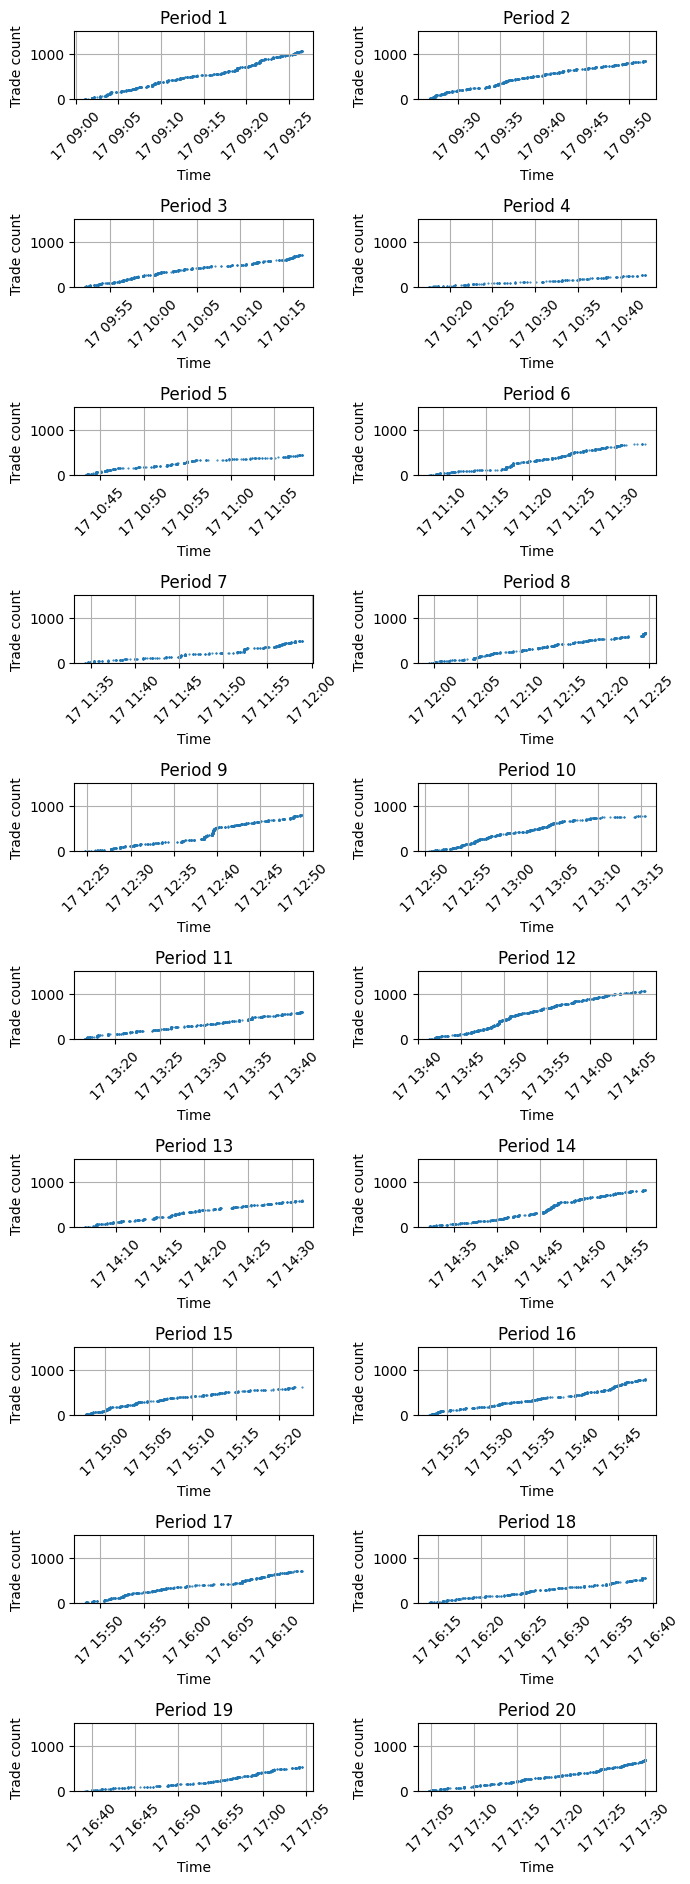

In [194]:
df_trades['day_period'] = pd.cut(df_trades.index, 
                                 bins=time_bins, include_lowest=True)
plt.figure(figsize=(7, 20))
for i, period in enumerate(df_trades['day_period'].cat.categories):
    period_data = df_trades[df_trades['day_period'] == period]
    ax = plt.subplot((num_periods // 2) + 1, 2, i + 1)
    plt.scatter(period_data.index, 
                np.arange(1, len(period_data) + 1), marker='.', s=1)
    plt.title(f'Period {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Trade count')
    plt.xticks(rotation=45)
    plt.ylim(0, 1500)
    plt.grid()

plt.tight_layout()
plt.show()

In [198]:
(end_time - start_time).total_seconds()

30531.577223

In [199]:
T = (end_time - start_time).total_seconds()
simulation = nhpp_thinning(f, T)
simulation

array([1.76936775e+00, 2.50130888e+00, 3.70209987e+00, ...,
       3.05285876e+04, 3.05293118e+04, 3.05307828e+04], shape=(13847,))

In [204]:
simulation_seconds = [start_time + pd.Timedelta(seconds=s) for s in simulation]
len(simulation_seconds), len(df_trades)

(13847, 13776)

##### Goodness-of-fit

In [ ]:
times = df_trades.iloc[:].index


lambda_data = np.array([Lambda(x, f) for x in 
                        (times - start_time).total_seconds()])
lambda_data_diff = np.diff(lambda_data)

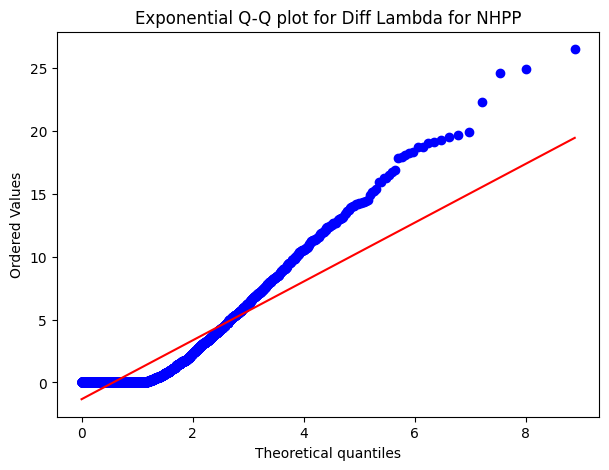

In [215]:
plt.figure(figsize=(7, 5))
stats.probplot(lambda_data_diff, dist='expon', sparams=(0, 1), plot=plt)
plt.title('Exponential Q-Q plot for Diff Lambda for NHPP')
plt.show()

In [216]:
stat, p_value = stats.kstest(
    lambda_data_diff, 'expon', args=(0, 1))
print("KS Test Statistic:", stat)
print("P-Value:", p_value)

KS Test Statistic: 0.6411057611206072
P-Value: 0.0


The model doesnt fit correctly the data. 

##### Statistical properties of the fitted model

In [226]:
times = df_trades.iloc[:].index
real_data = np.array((times - start_time).total_seconds())
real_data[:10]

array([0.      , 0.024273, 0.024547, 0.219534, 0.219546, 0.242859,
       0.243053, 1.330585, 1.330591, 6.082496])

In [227]:
simulation[:10]

array([1.76936775, 2.50130888, 3.70209987, 3.95708807, 4.2221187 ,
       7.05143495, 7.24784638, 9.13958484, 9.69089139, 9.79549491])

In [228]:
len(real_data), len(simulation)

(13776, 13847)

In [234]:
pd.DataFrame(real_data).describe()

,0
count,13776.000000
mean,15093.664982
std,8897.641912
min,0.000000
25%,7970.441755
50%,15546.270231
75%,22307.336402
max,30531.577223


In [236]:
pd.DataFrame(real_data).kurt(), pd.DataFrame(real_data).skew()

(0   -1.12286
 dtype: float64,
 0   -0.076182
 dtype: float64)

In [233]:
pd.DataFrame(simulation).describe()

,0
count,13847.000000
mean,15055.989258
std,8950.148669
min,1.769368
25%,7668.079405
50%,15412.741374
75%,22636.878446
max,30530.782761


In [237]:
pd.DataFrame(simulation).kurt(), pd.DataFrame(simulation).skew()

(0   -1.155908
 dtype: float64,
 0   -0.065451
 dtype: float64)

We can see that from the statistical properties, in general the simulated model follows the statistical properties of the data. the only problem, is that in the real data, sometimes are very fast trades which are not captured by the model. This is why the model doesnt fit the data correctly.

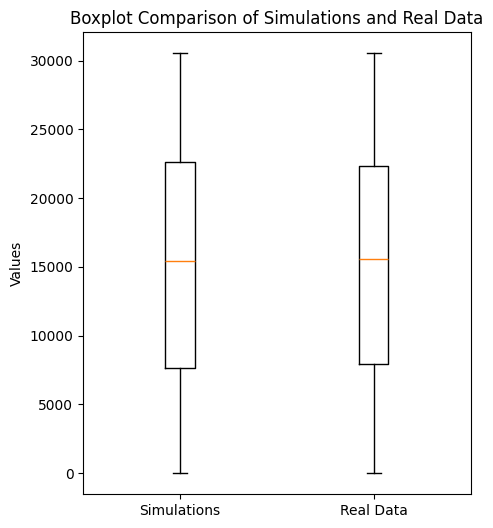

In [240]:
plt.figure(figsize=(5, 6)) 
plt.boxplot([simulation, real_data], tick_labels=['Simulations', 'Real Data'])

plt.title('Boxplot Comparison of Simulations and Real Data')
plt.ylabel('Values')

plt.show()

In [252]:
lambda_data = np.array([Lambda(x, f) for x in 
                        real_data])
lambda_data_diff = np.diff(lambda_data)

In [253]:
lambda_simulations = np.array([Lambda(x, f) for x in
                                 simulation])
lambda_simulations_diff = np.diff(lambda_simulations)

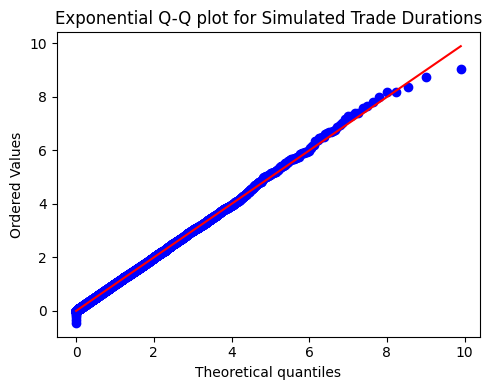

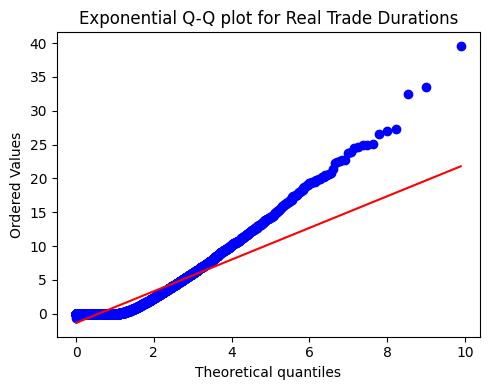

In [254]:
plt.figure(figsize=(5, 4))
stats.probplot(lambda_simulations_diff, dist='expon', sparams=(0, 1), plot=plt)
plt.title('Exponential Q-Q plot for Simulated Trade Durations')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
stats.probplot(lambda_data_diff, dist='expon', sparams=(0, 1), plot=plt)
plt.title('Exponential Q-Q plot for Real Trade Durations')
plt.tight_layout()
plt.show()

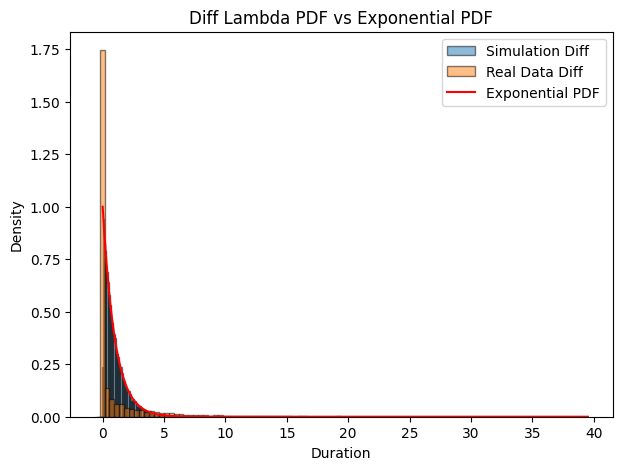

In [255]:
x = np.linspace(0, np.max([
    np.max(lambda_simulations_diff), np.max(lambda_data_diff)
    ]), 1000)
pdf = expon.pdf(x, scale=1)

plt.figure(figsize=(7, 5))
plt.hist(lambda_simulations_diff, edgecolor="black", bins=100, density=True, alpha=0.5, label='Simulation Diff')
plt.hist(lambda_data_diff, edgecolor="black", bins=100, density=True, alpha=0.5, label='Real Data Diff')
plt.plot(x, pdf, label='Exponential PDF', color='r')
plt.title('Diff Lambda PDF vs Exponential PDF')
plt.xlabel('Duration')
plt.ylabel('Density')
plt.legend()
plt.show()


The simulations perform under the statistical expectations, however, the data doesnt, so in the end, the model is not a good fit for the data. This is specially true for the fat tails of the data and the concentration on the values near 0.

## Question 2

**Brownian motions with Poisson sampling.**

Consider two processes $ p_i(t) = \sigma_i W_i(t) $, $ i = 1,2 $, where $ W_1 $ and $ W_2 $ are two Brownian motions such that $\langle W_1, W_2 \rangle_t = \rho t$ for some constants $\sigma_1 > 0$, $\sigma_2 > 0$, and $\rho \in ]-1, 1[$. Assume that for $ i = 1,2 $ the process $ p_i $ is observed on $[0,T]$ at times $T_{i,k},\, k \geq 0$, and that $(T_{i,k})_{k \geq 0}$ is a Poisson process with constant intensity $\mu_i > 0$. Such a framework could be used to model the trade times and log-trade prices for two correlated assets.

Simulate multiple sample paths of the *observed* processes (trade times and prices) and on each path compute the standard covariance estimator of $[p_1, p_2]_t = \rho \sigma_1 \sigma_2 t$ at various sampling periods $\tau$. Comment.

In [13]:
rho = 0.4
mu = [0.4, 0.6]
max_time = 10_000
sigmas = [0.5, 0.2]

T1 = time_homogeneous_poisson_process(mu[0], max_time)
T2 = time_homogeneous_poisson_process(mu[1], max_time)

T1 = np.concat([[0], T1])
T2 = np.concat([[0], T2])

In [14]:
def simulated_correlated_BMs (rho : float, 
                              sigmas : List[float], 
                              T : List[np.ndarray], 
                              seed : int = None):
    
    if seed is not None:
        np.random.seed(seed)
    else:
        #np.random.seed(42)
        pass
    
    Ts = np.sort( np.unique( np.concatenate(T) ) )
    dTs = np.diff(Ts)
        
    n_steps = len(dTs)    
        
    W1 = np.zeros(n_steps + 1)
    W2 = np.zeros(n_steps + 1)
    
    for i in range(n_steps):
        Z1 = np.random.normal(0, 1)
        Z2 = np.random.normal(0, 1)
        
        dW1 = np.sqrt(dTs[i]) * Z1
        dW2 = np.sqrt(dTs[i]) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)
        
        W1[i + 1] = W1[i] + dW1
        W2[i + 1] = W2[i] + dW2
        
    p1 = sigmas[0] * W1
    p2 = sigmas[1] * W2
    
    df = pd.DataFrame({
        'p1': p1,
        'p2': p2
    }, index = Ts)
    
    return df

In [15]:
df_simulation = simulated_correlated_BMs(rho, sigmas, [T1, T2])
df_simulation.head()

,p1,p2
0.000000,0.000000,0.000000
1.566902,0.377994,0.274111
2.093382,0.552626,0.438580
2.724906,1.176555,0.724083
5.295258,1.288121,0.452829


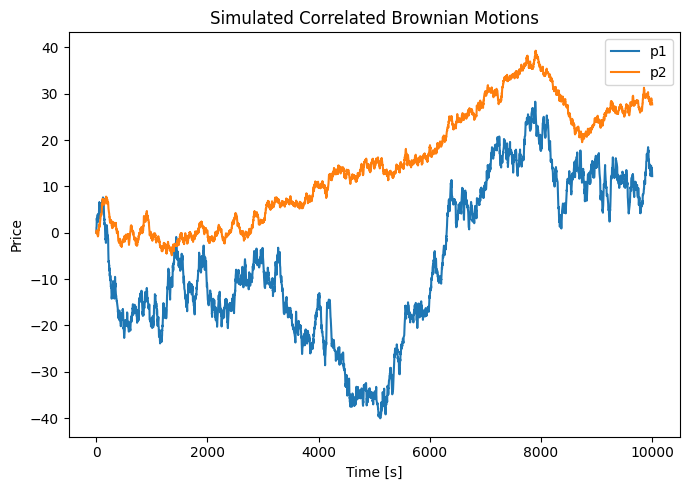

In [16]:
plt.figure(figsize=(7, 5))
plt.plot(df_simulation.loc[T1].index, df_simulation.loc[T1]['p1'], label='p1')
plt.plot(df_simulation.loc[T2].index, df_simulation.loc[T2]['p2'], label='p2')
plt.xlabel('Time [s]')
plt.ylabel('Price')
plt.legend()
plt.title('Simulated Correlated Brownian Motions')
plt.tight_layout()
plt.show()

##### Estimating standard covariance estimator $[p1, p2]_t = \rho \sigma1 \sigma2 t$

In [17]:
N_sims = 100
tau_list = [0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 2, 5]
cov_estimates = {tau : [] for tau in tau_list}

rho = 0.5
mu = [0.4, 0.6]
max_time = 1_000
sigmas = [0.5, 0.2]

In [55]:
N_sims = 1
tau_list = [0.5]

for rep in range(N_sims):

    T1 = time_homogeneous_poisson_process(mu[0], max_time)
    T2 = time_homogeneous_poisson_process(mu[1], max_time)

    T1 = np.concat([[0], T1])
    T2 = np.concat([[0], T2])
    
    df_sim = simulated_correlated_BMs(rho, sigmas, [T1, T2])
    
    for tau in tau_list:
        
        df_sim_time = df_sim.sort_index().copy()
        df_sim_time.index = pd.to_datetime(
            df_sim_time.index, unit='s', origin='unix'
        )
        
        start_dt = df_sim_time.index.min()
        end_dt = df_sim_time.index.max()
        new_index = pd.date_range(start=start_dt, end=end_dt, freq=f'1S')        
        
        df_sim_interpolated = (df_sim_time
                               .reindex(new_index)
                               .mean()
                               .interpolate(
                                   method='time', limit_direction='both')
                               )

        plt.figure(figsize=(7, 5))
        plt.plot(df_sim_interpolated['p1'], label='p1')
        plt.plot(df_sim_interpolated['p2'], label='p2')
        plt.xlabel('Time [s]')
        plt.ylabel('Price')
        plt.legend()
        plt.title('Simulated Correlated Brownian Motions')
        plt.tight_layout()
        plt.show()
        
        dp1 = np.diff(df_sim_interpolated['p1'])
        dp2 = np.diff(df_sim_interpolated['p2'])
        
        rcov = np.sum(dp1 * dp2)
        
        cov_estimates[tau].append(rcov)       

C:\Users\Marti\AppData\Local\Temp\ipykernel_3208\1008962802.py:23: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  new_index = pd.date_range(start=start_dt, end=end_dt, freq=f'1S')


ValueError: time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex

In [53]:
import pandas as pd
import numpy as np

# Fake times: 0, 1, 2 seconds
df_test = pd.DataFrame(
    {'p1': [0, 1, 5], 'p2': [3, 1, 0]}, 
    index=[0, 1, 2]
)

df_test = df_sim.sort_index().copy()

df_test.index.name = 'time_s'
print(df_test)

# Convert index to DateTime
df_test.index = pd.to_datetime(df_test.index, unit='s', origin='unix')
print("\nAs DateTime:\n", df_test)

# Reindex with 0.5 second frequency
start_dt = df_test.index.min()
end_dt = df_test.index.max()
new_index = pd.date_range(start=start_dt, end=end_dt, freq='0.1s')

df_test_interp = (df_test
                  .reindex(new_index).mean()
                  .interpolate(method='time', limit_direction='both'))

print("\nInterpolated:\n", df_test_interp)


                  p1        p2
time_s                        
0.000000    0.000000  0.000000
0.432490   -0.039870 -0.120829
2.375629    0.743397  0.260220
2.872537    0.479766  0.305369
5.686019   -0.357684 -0.385426
...              ...       ...
995.443071  5.666289  0.250984
996.122845  5.636929 -0.026492
996.781380  6.354661  0.550024
998.275305  6.540969  0.700278
998.522178  7.156791  0.830593

[942 rows x 2 columns]

As DateTime:
                                      p1        p2
time_s                                           
1970-01-01 00:00:00.000000000  0.000000  0.000000
1970-01-01 00:00:00.432489868 -0.039870 -0.120829
1970-01-01 00:00:02.375629010  0.743397  0.260220
1970-01-01 00:00:02.872537181  0.479766  0.305369
1970-01-01 00:00:05.686019388 -0.357684 -0.385426
...                                 ...       ...
1970-01-01 00:16:35.443070971  5.666289  0.250984
1970-01-01 00:16:36.122845486  5.636929 -0.026492
1970-01-01 00:16:36.781379526  6.354661  0.550024
1970-01-

ValueError: time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex

In [47]:
import pandas as pd
import numpy as np

# Fake times: 0, 1, 2 seconds
df_test = pd.DataFrame(
    {'p1': [0, 1, 5], 'p2': [3, 1, 0]}, 
    index=[0, 1, 2]
)



df_test.index.name = 'time_s'
print(df_test)

# Convert index to DateTime
df_test.index = pd.to_datetime(df_test.index, unit='s', origin='unix')
print("\nAs DateTime:\n", df_test)

# Reindex with 0.5 second frequency
start_dt = df_test.index.min()
end_dt = df_test.index.max()
new_index = pd.date_range(start=start_dt, end=end_dt, freq='0.1S')

df_test_interp = (df_test
                  .reindex(new_index)
                  .interpolate(method='time', limit_direction='both'))

print("\nInterpolated:\n", df_test_interp)


        p1  p2
time_s        
0        0   3
1        1   1
2        5   0

As DateTime:
                      p1  p2
time_s                     
1970-01-01 00:00:00   0   3
1970-01-01 00:00:01   1   1
1970-01-01 00:00:02   5   0

Interpolated:
                           p1   p2
1970-01-01 00:00:00.000  0.0  3.0
1970-01-01 00:00:00.100  0.1  2.8
1970-01-01 00:00:00.200  0.2  2.6
1970-01-01 00:00:00.300  0.3  2.4
1970-01-01 00:00:00.400  0.4  2.2
1970-01-01 00:00:00.500  0.5  2.0
1970-01-01 00:00:00.600  0.6  1.8
1970-01-01 00:00:00.700  0.7  1.6
1970-01-01 00:00:00.800  0.8  1.4
1970-01-01 00:00:00.900  0.9  1.2
1970-01-01 00:00:01.000  1.0  1.0
1970-01-01 00:00:01.100  1.4  0.9
1970-01-01 00:00:01.200  1.8  0.8
1970-01-01 00:00:01.300  2.2  0.7
1970-01-01 00:00:01.400  2.6  0.6
1970-01-01 00:00:01.500  3.0  0.5
1970-01-01 00:00:01.600  3.4  0.4
1970-01-01 00:00:01.700  3.8  0.3
1970-01-01 00:00:01.800  4.2  0.2
1970-01-01 00:00:01.900  4.6  0.1
1970-01-01 00:00:02.000  5.0  0.0


C:\Users\Marti\AppData\Local\Temp\ipykernel_3208\2992500645.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  new_index = pd.date_range(start=start_dt, end=end_dt, freq='0.1S')


In [19]:
for tau in tau_list:
    avg_cov = np.mean(cov_estimates[tau])
    std_cov = np.std(cov_estimates[tau])
    theo_cov = rho * sigmas[0] * sigmas[1] * tau
    print(f'Tau: {tau} | Average Cov: {avg_cov:.4f}',
          f'| Std Cov: {std_cov:.4f}',
          f"| theoretical: {theo_cov:.4f}")
    
theoretical = rho * sigmas[0] * sigmas[1] * 0.01
print(f'Theoretical Cov: {theoretical}')

Tau: 0.001 | Average Cov: 49.8036 | Std Cov: 4.6429 | theoretical: 0.0001
Tau: 0.01 | Average Cov: 49.8036 | Std Cov: 4.6429 | theoretical: 0.0005
Tau: 0.1 | Average Cov: 49.8036 | Std Cov: 4.6429 | theoretical: 0.0050
Tau: 0.2 | Average Cov: 49.8036 | Std Cov: 4.6429 | theoretical: 0.0100
Tau: 0.5 | Average Cov: 49.8036 | Std Cov: 4.6429 | theoretical: 0.0250
Tau: 1.0 | Average Cov: 49.8036 | Std Cov: 4.6429 | theoretical: 0.0500
Tau: 2 | Average Cov: 49.8036 | Std Cov: 4.6429 | theoretical: 0.1000
Tau: 5 | Average Cov: 49.8036 | Std Cov: 4.6429 | theoretical: 0.2500
Theoretical Cov: 0.0005


Tau: 0.001 | Average Cov: 49.80362431841356 | Std Cov: 4.6429122003863785
Tau: 0.01 | Average Cov: 49.80362431841356 | Std Cov: 4.6429122003863785
Tau: 0.1 | Average Cov: 49.80362431841356 | Std Cov: 4.6429122003863785
Tau: 0.2 | Average Cov: 49.80362431841356 | Std Cov: 4.6429122003863785
Tau: 0.5 | Average Cov: 49.80362431841356 | Std Cov: 4.6429122003863785
Tau: 1.0 | Average Cov: 49.80362431841356 | Std Cov: 4.6429122003863785
Tau: 2 | Average Cov: 49.80362431841356 | Std Cov: 4.6429122003863785
Tau: 5 | Average Cov: 49.80362431841356 | Std Cov: 4.6429122003863785
Theoretical Cov: 50.0


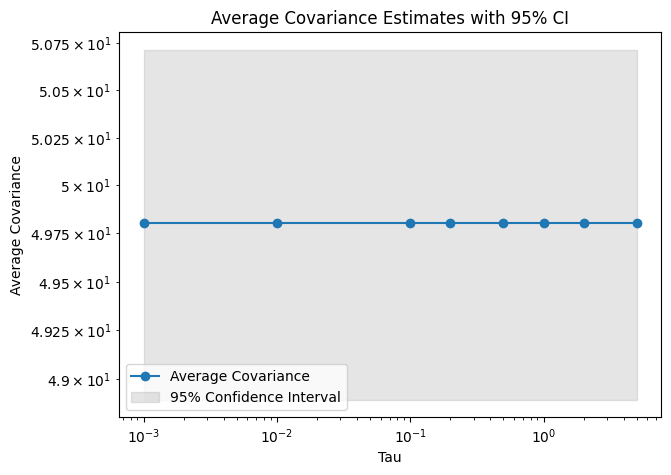

In [20]:
avg_cov_list = []
theo_cov_list = []
ci_lower = []
ci_upper = []

for tau in tau_list:
    data = cov_estimates[tau]
    avg = np.mean(data)
    std = np.std(data)
    n = len(data)
    se = std / np.sqrt(n)
    avg_cov_list.append(avg)
    ci_lower.append(avg - 1.96 * se)
    ci_upper.append(avg + 1.96 * se)
    theo_cov_list.append(rho * sigmas[0] * sigmas[1] * tau)
    print(f'Tau: {tau} | Average Cov: {avg} | Std Cov: {std}')

theoretical = rho * sigmas[0] * sigmas[1] * max_time
print(f'Theoretical Cov: {theoretical}')

plt.figure(figsize=(7, 5))
plt.plot(tau_list, avg_cov_list, marker='o', label='Average Covariance')
plt.fill_between(tau_list, ci_lower, ci_upper, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Average Covariance Estimates with 95% CI')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Tau')
plt.ylabel('Average Covariance')
plt.legend()
plt.show()